In [105]:
import pandas as pd
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima,ARIMA
from sklearn.model_selection import GridSearchCV
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import Holt, ExponentialSmoothing
import matplotlib.pyplot as plt

In [2]:
df= pd.read_excel('Sales_Forecast_Data.xlsx')

In [3]:
df.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
0,2014-2015,Nov,Haryana,Insecticides,Rohtak,monous,675.00
1,2014-2015,Nov,Haryana,Insecticides,Rewari,monous,73.71
2,2014-2015,Nov,Haryana,Insecticides,Gurgaon,monous,405.00
3,2014-2015,Nov,Haryana,Insecticides,Mewat,monous,1188.00
4,2014-2015,Nov,Haryana,Insecticides,Palwal,monous,5188.59


# data preprocessing

In [4]:
df.isna().sum()

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [5]:
df1= df[df['COMPANY']==('ABC Manufacturing')]

In [6]:
df1.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
49,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380
50,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250
51,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635
52,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910
53,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110


# data visualisation

<AxesSubplot:xlabel='STATE', ylabel='count'>

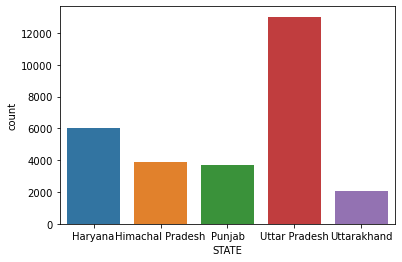

In [7]:
sns.countplot(x='STATE', data= df1)

<AxesSubplot:xlabel='STATE', ylabel='VALUE'>

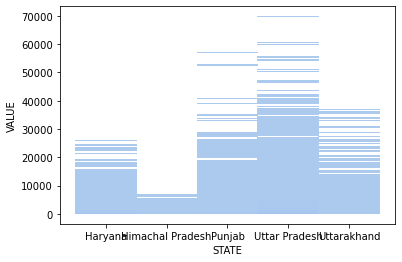

In [8]:
sns.histplot(x='STATE',y='VALUE',data= df1)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28640 entries, 49 to 230147
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FIN_YEAR  28640 non-null  object 
 1   MONTH     28640 non-null  object 
 2   STATE     28640 non-null  object 
 3   FG        28640 non-null  object 
 4   DISTRICT  28640 non-null  object 
 5   COMPANY   28640 non-null  object 
 6   VALUE     28640 non-null  float64
dtypes: float64(1), object(6)
memory usage: 2.8+ MB


# Deriving the date column

In [10]:
dataset=df1.copy()
#renaming the month column to numbers
dataset['MONTH'] = dataset['MONTH'].str.replace('Jan', '1')
dataset['MONTH'] = dataset['MONTH'].str.replace('Feb', '2')
dataset['MONTH'] = dataset['MONTH'].str.replace('Mar', '3')
dataset['MONTH'] = dataset['MONTH'].str.replace('Apr', '4')
dataset['MONTH'] = dataset['MONTH'].str.replace('May', '5')
dataset['MONTH'] = dataset['MONTH'].str.replace('Jun', '6')
dataset['MONTH'] = dataset['MONTH'].str.replace('Jul', '7')
dataset['MONTH'] = dataset['MONTH'].str.replace('Aug', '8')
dataset['MONTH'] = dataset['MONTH'].str.replace('Sep', '9')
dataset['MONTH'] = dataset['MONTH'].str.replace('Oct', '10')
dataset['MONTH'] = dataset['MONTH'].str.replace('Nov', '11')
dataset['MONTH'] = dataset['MONTH'].str.replace('Dec', '12')

In [11]:
#seperating the datasets with respect to months 
jan_data=dataset.loc[dataset['MONTH']=="1"]
feb_data=dataset.loc[dataset['MONTH']=="2"]
mar_data=dataset.loc[dataset['MONTH']=="3"]
apr_data=dataset.loc[dataset['MONTH']=="4"]
may_data=dataset.loc[dataset['MONTH']=="5"]
jun_data=dataset.loc[dataset['MONTH']=="6"]
jul_data=dataset.loc[dataset['MONTH']=="7"]
aug_data=dataset.loc[dataset['MONTH']=="8"]
sep_data=dataset.loc[dataset['MONTH']=="9"]
oct_data=dataset.loc[dataset['MONTH']=="10"]
nov_data=dataset.loc[dataset['MONTH']=="11"]
dec_data=dataset.loc[dataset['MONTH']=="12"]

In [12]:
#combining the data into quarters
Q4_data=pd.concat([jan_data,feb_data,mar_data]).reset_index().drop("index",axis=1)
Q1_data=pd.concat([apr_data,may_data,jun_data]).reset_index().drop("index",axis=1)
Q2_data=pd.concat([jul_data,aug_data,sep_data]).reset_index().drop("index",axis=1)
Q3_data=pd.concat([oct_data,nov_data,dec_data]).reset_index().drop("index",axis=1)

In [13]:
#since the Q4 data falls into a new year in the year cycle we need to rename the year to latter year in cycle
#that is 2014-2015  jan(2015) so rename the year to 2015
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2014-2015', '2015')
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2015-2016', '2016')
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2016-2017', '2017')
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2017-2018', '2018')

Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2014-2015', '2014')
Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2015-2016', '2015')
Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2016-2017', '2016')
Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2017-2018', '2017')

Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2014-2015', '2014')
Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2015-2016', '2015')
Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2016-2017', '2016')
Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2017-2018', '2017')

Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2014-2015', '2014')
Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2015-2016', '2015')
Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2016-2017', '2016')
Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2017-2018', '2017')

In [14]:
#combining the quarters data in to a dataset
dataset_new=pd.concat([Q1_data,Q2_data,Q3_data,Q4_data]).reset_index().drop("index",axis=1)

In [15]:
dataset_new["date"]=pd.to_datetime(dataset_new["FIN_YEAR"]+"-"+dataset_new["MONTH"]+"-"+"1")

In [16]:
#removing the unnecessary columns
dataset_new.drop(["FIN_YEAR","MONTH",'FG','DISTRICT','COMPANY'],axis=1,inplace=True)

In [17]:
dataset_new

,STATE,VALUE,date
0,Haryana,438.750,2014-04-01
1,Haryana,89.100,2014-04-01
2,Haryana,2937.060,2014-04-01
3,Haryana,3034.125,2014-04-01
4,Haryana,5320.890,2014-04-01
...,...,...,...
28635,Punjab,0.000,2017-03-01
28636,Punjab,0.000,2017-03-01
28637,Punjab,0.000,2017-03-01
28638,Punjab,0.000,2017-03-01


In [18]:
#first creation of seperate detasets for each state:
Himachal_dataset=dataset_new.loc[dataset_new['STATE']=='Himachal Pradesh']
Haryana_dataset=dataset_new.loc[dataset_new['STATE']=='Haryana']
Uttar_Pradesh_dataset=dataset_new.loc[dataset_new['STATE']=='Uttar Pradesh']
Punjab_dataset=dataset_new.loc[dataset_new['STATE']=='Punjab']
Uttarakhand_dataset=dataset_new.loc[dataset_new['STATE']=='Uttarakhand']

In [19]:
#drop the state column in all datasets
Himachal_dataset.drop(["STATE"],axis=1,inplace=True)
Haryana_dataset.drop(["STATE"],axis=1,inplace=True)
Uttar_Pradesh_dataset.drop(["STATE"],axis=1,inplace=True)
Punjab_dataset.drop(["STATE"],axis=1,inplace=True)
Uttarakhand_dataset.drop(["STATE"],axis=1,inplace=True)

C:\Users\91738\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
Himachal_dataset=Himachal_dataset.sort_values("date").reset_index().drop("index",axis=1)

In [21]:
#rearranging the datasets in cronological order
Himachal_dataset=Himachal_dataset.sort_values("date").reset_index().drop("index",axis=1)
Haryana_dataset=Haryana_dataset.sort_values("date").reset_index().drop("index",axis=1)
Uttarakhand_dataset=Uttarakhand_dataset.sort_values("date").reset_index().drop("index",axis=1)
Punjab_dataset=Punjab_dataset.sort_values("date").reset_index().drop("index",axis=1)
Uttar_Pradesh_dataset=Uttar_Pradesh_dataset.sort_values("date").reset_index().drop("index",axis=1)

In [22]:
Haryana_dataset

,VALUE,date
0,438.750,2014-04-01
1,0.000,2014-04-01
2,13.905,2014-04-01
3,3.780,2014-04-01
4,5.400,2014-04-01
...,...,...
6023,146.880,2018-01-01
6024,136.080,2018-01-01
6025,0.000,2018-01-01
6026,57.375,2018-01-01


In [23]:
#adding the monthly sales 
Uttarakhand_dataset=Uttarakhand_dataset.groupby('date')['VALUE'].sum().reset_index()
Punjab_dataset=Punjab_dataset.groupby('date')['VALUE'].sum().reset_index()
Uttar_Pradesh_dataset=Uttar_Pradesh_dataset.groupby('date')['VALUE'].sum().reset_index()
Haryana_dataset=Haryana_dataset.groupby('date')['VALUE'].sum().reset_index()
Himachal_dataset=Himachal_dataset.groupby('date')['VALUE'].sum().reset_index()

In [24]:
#setting the date as index
Punjab_dataset.set_index("date",inplace=True)
Uttarakhand_dataset.set_index("date",inplace=True)
Uttar_Pradesh_dataset.set_index("date",inplace=True)
Haryana_dataset.set_index("date",inplace=True)
Himachal_dataset.set_index("date",inplace=True)

In [25]:
Punjab_dataset

,VALUE
date,
2014-04-01,181633.185
2014-05-01,184528.935
2014-06-01,151493.085
2014-07-01,99722.475
2014-08-01,149691.915
2014-09-01,115486.965
2014-10-01,305785.800
2014-11-01,183920.490
2014-12-01,198224.280


# Visualisation for the sales in various states

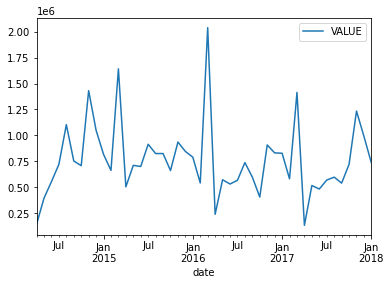

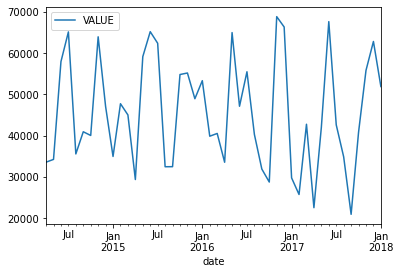

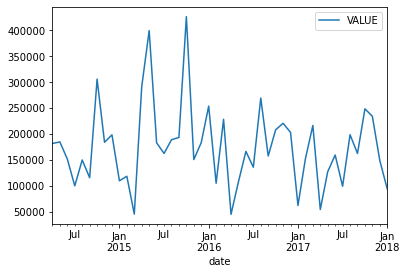

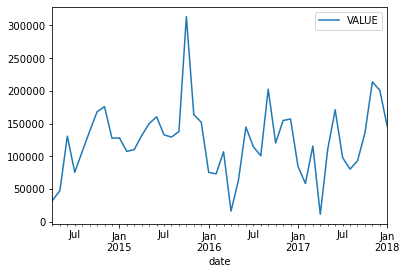

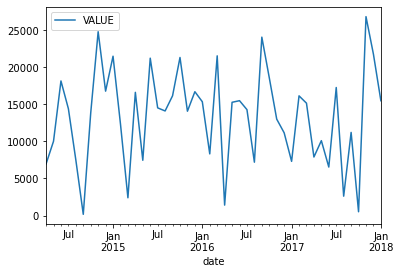

In [26]:
datasets=[Uttar_Pradesh_dataset,Uttarakhand_dataset,Punjab_dataset,Haryana_dataset,Himachal_dataset]
for i in datasets:
    i.plot()

# Checking for stationality of data


In [27]:
datasets={'Uttar_Pradesh':Uttar_Pradesh_dataset,
          'Uttarkhand':Uttarakhand_dataset,
          'Punjab':Punjab_dataset,
          'Haryana':Haryana_dataset,
          'Himachal':Himachal_dataset}
for j,i in datasets.items():
    print('############################')
    print(j)
    X= i.VALUE
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    

############################
Uttar_Pradesh
ADF Statistic: -7.642922
p-value: 0.000000
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602
############################
Uttarkhand
ADF Statistic: -1.425152
p-value: 0.570160
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
############################
Punjab
ADF Statistic: -6.179226
p-value: 0.000000
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602
############################
Haryana
ADF Statistic: -4.757896
p-value: 0.000065
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602
############################
Himachal
ADF Statistic: -7.021483
p-value: 0.000000
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


the p value is very less than the 0.05 except for Uttarkhand hence we can reject the null hypothesis and take
that the series is stationary


for Uttarkhand the data is non stationary

# Visualising the trend and seasonal component in every state dataset

In [28]:
Punjab_dataset

,VALUE
date,
2014-04-01,181633.185
2014-05-01,184528.935
2014-06-01,151493.085
2014-07-01,99722.475
2014-08-01,149691.915
2014-09-01,115486.965
2014-10-01,305785.800
2014-11-01,183920.490
2014-12-01,198224.280


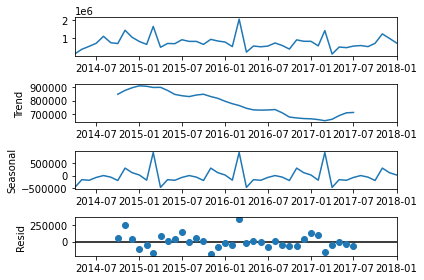

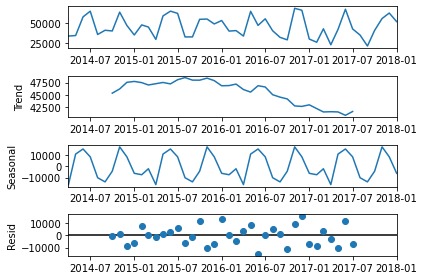

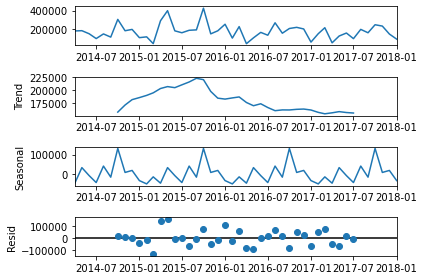

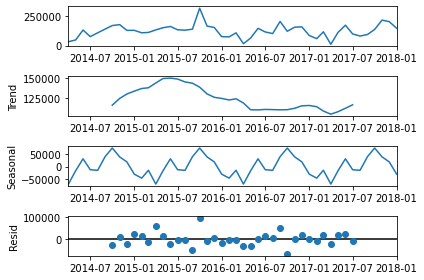

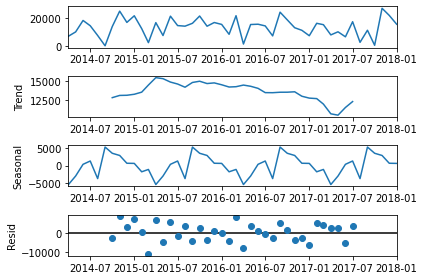

In [29]:
for j,i in datasets.items():
    Decomposed_Series = seasonal_decompose(i)
    Decomposed_Series.plot()
    

# sampling the data into train and test in every state dataset

In [30]:
#split the data into train,test
train_Himachal_dataset=Himachal_dataset[0:33]
test_Himachal_dataset=Himachal_dataset[33:]
train_Punjab_dataset=Punjab_dataset[0:33]
test_Punjab_dataset=Punjab_dataset[33:]
train_Uttarakhand_dataset=Uttarakhand_dataset[0:33]
test_Uttarakhand_dataset=Uttarakhand_dataset[33:]
train_Haryana_dataset=Haryana_dataset[0:33]
test_Haryana_dataset=Haryana_dataset[33:]
train_Uttar_Pradesh_dataset=Uttar_Pradesh_dataset[0:33]
test_Uttar_Pradesh_dataset=Uttar_Pradesh_dataset[33:]

# Model building

In [72]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))

In [73]:
P = D = Q = range(0,2)
S = list(itertools.product(p, d, q))
PDQ=[]
for i in s:#range(0,5):
    PDQ.append((i[0],i[1],i[2],6))

In [75]:
#model for himachal_pradesh
PDQList,pdqList,mapeList=[],[],[]
for param in pdq:
    for param_seasonal in PDQ:
        #train=train_Himachal_dataset
        train=np.log(train_Himachal_dataset)
        model = ARIMA(param,param_seasonal).fit(train)
        Forecast = pd.Series(model.predict(13)).rename('Forecast')
        Forecast = np.exp(Forecast)
        Forecast.index = test_Himachal_dataset.index
        Actual_Forecast_Df = pd.concat([Himachal_dataset, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-13:].copy()
        tempMAPE = np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE
        pdqList.append(param)
        PDQList.append(param_seasonal)
        mapeList.append(tempMAPE)
arimaEvaluationDf = pd.DataFrame({"pdq": pdqList,"PDQ": PDQList,"MAPE": mapeList})
arimaEvaluationDf.MAPE.sort_values()

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. 

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. A

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too 

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


183    7.344958e+01
167    7.443902e+01
182    8.873200e+01
412    8.881324e+01
360    8.976745e+01
           ...     
460    2.576191e+08
76     1.007598e+09
332    1.009583e+09
268    1.013611e+09
12     1.015593e+09
Name: MAPE, Length: 512, dtype: float64

In [76]:
arimaEvaluationDf.sort_values('MAPE').reset_index().iloc[0]

pdq        (0, 1, 0)
PDQ     (3, 1, 3, 6)
MAPE       73.449579
Name: 183, dtype: object

In [79]:
#model for punjab dataset
PDQList,pdqList,mapeList=[],[],[]
for param in pdq:
    for param_seasonal in PDQ:
        #train=train_Punjab_dataset
        train=np.log(train_Punjab_dataset)
        model = ARIMA(param,param_seasonal).fit(train)
        Forecast = pd.Series(model.predict(13)).rename('Forecast')
        Forecast = np.exp(Forecast)
        Forecast.index = test_Punjab_dataset.index
        Actual_Forecast_Df = pd.concat([Punjab_dataset, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-13:].copy()
        tempMAPE = np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE
        pdqList.append(param)
        PDQList.append(param_seasonal)
        mapeList.append(tempMAPE)
arimaEvaluationDf = pd.DataFrame({"pdq": pdqList,"PDQ": PDQList,"MAPE": mapeList})
arimaEvaluationDf.MAPE.sort_values()

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. 

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary star

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible sta

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\si

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

344    3.353540e+01
212    3.505377e+01
468    3.515152e+01
345    3.780514e+01
25     4.033427e+01
           ...     
510    7.058399e+10
479    8.969911e+10
477    9.062839e+10
508    2.272593e+11
509    2.862332e+11
Name: MAPE, Length: 512, dtype: float64

In [80]:
arimaEvaluationDf.sort_values('MAPE').reset_index().iloc[0]

pdq        (1, 0, 1)
PDQ     (1, 2, 0, 6)
MAPE       33.535396
Name: 344, dtype: object

In [82]:
#model for uttarakhand dataset
PDQList,pdqList,mapeList=[],[],[]
for param in pdq:
    for param_seasonal in PDQ:
        #train=train_Uttarakhand_dataset
        train=np.log(train_Uttarakhand_dataset)
        model = ARIMA(param,param_seasonal).fit(train)
        Forecast = pd.Series(model.predict(13)).rename('Forecast')
        Forecast = np.exp(Forecast)
        Forecast.index = test_Uttarakhand_dataset.index
        Actual_Forecast_Df = pd.concat([Uttarakhand_dataset, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-13:].copy()
        tempMAPE = np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE
        pdqList.append(param)
        PDQList.append(param_seasonal)
        mapeList.append(tempMAPE)
arimaEvaluationDf = pd.DataFrame({"pdq": pdqList,"PDQ": PDQList,"MAPE": mapeList})
arimaEvaluationDf.MAPE.sort_values()

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zero

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [93]:
arimaEvaluationDf.sort_values('MAPE').reset_index().iloc[0]

index             344
pdq         (1, 0, 1)
PDQ      (1, 2, 0, 6)
MAPE        33.535396
Name: 0, dtype: object

In [ ]:
#model for utterpradesh dataset
PDQList,pdqList,mapeList=[],[],[]
for param in pdq:
    for param_seasonal in PDQ:
        train=np.log(train_Uttar_Pradesh_dataset)
        #train=train_Uttar_Pradesh_dataset
        model = ARIMA(param,param_seasonal).fit(train)
        Forecast = pd.Series(model.predict(13)).rename('Forecast')
        Forecast = np.exp(Forecast)
        Forecast.index = test_Uttar_Pradesh_dataset.index
        Actual_Forecast_Df = pd.concat([Uttar_Pradesh_dataset, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-13:].copy()
        tempMAPE = np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE
        pdqList.append(param)
        PDQList.append(param_seasonal)
        mapeList.append(tempMAPE)
arimaEvaluationDf = pd.DataFrame({"pdq": pdqList,"PDQ": PDQList,"MAPE": mapeList})
arimaEvaluationDf.MAPE.sort_values()

In [ ]:
arimaEvaluationDf.sort_values('MAPE').reset_index().iloc[0]

In [94]:
from sklearn.metrics import mean_squared_error
import math
#model for haryana dataset
PDQList,pdqList,mapeList,rmselist=[],[],[],[]
for param in pdq:
    for param_seasonal in PDQ:
        #train=train_Haryana_dataset
        train=np.log(train_Haryana_dataset)
        model = ARIMA(param,param_seasonal).fit(train)
        Forecast = pd.Series(model.predict(13)).rename('Forecast')
        Forecast = np.exp(Forecast)
        Forecast.index = test_Haryana_dataset.index
        Actual_Forecast_Df = pd.concat([Haryana_dataset, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-13:].copy()
        tempMAPE = np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE
        rslt_meansqre_err = mean_squared_error(Validation_Df['VALUE'], Validation_Df['Forecast'])
        root_meansqre_err = math.sqrt(rslt_meansqre_err)
        pdqList.append(param)
        PDQList.append(param_seasonal)
        mapeList.append(tempMAPE)
        rmselist.append(root_meansqre_err)
arimaEvaluationDf = pd.DataFrame({"pdq": pdqList,"PDQ": PDQList,"MAPE": mapeList,"RMSE":rmselist})
arimaEvaluationDf.MAPE.sort_values()

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too 

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zero

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optim

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary star

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\a

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

37     3.985850e+01
26     3.994813e+01
282    4.005107e+01
85     4.025578e+01
344    4.054533e+01
           ...     
236    1.551552e+11
239    1.584685e+11
237    1.796132e+11
238    1.998762e+11
222    3.859721e+11
Name: MAPE, Length: 512, dtype: float64

In [95]:
arimaEvaluationDf.sort_values('MAPE').reset_index().iloc[0]

index              37
pdq         (0, 0, 0)
PDQ      (2, 1, 1, 6)
MAPE        39.858495
RMSE     41171.960485
Name: 0, dtype: object

#the best parameters for each state so far with seasonality 12 (with log transform)

himachal pradesh:
pdq         (0, 1, 0)
PDQ     (1, 1, 0, 12)
MAPE        129.74664

punjab:
pdq         (1, 1, 1)
PDQ     (0, 1, 1, 12)
MAPE        40.817994

uttarakhand:
pdq         (1, 1, 1)
PDQ     (1, 1, 0, 12)
MAPE        25.586546

utter pradesh:
pdq         (0, 0, 1)
PDQ     (0, 1, 1, 12)
MAPE        19.521748

haryana:
pdq         (0, 0, 0)
PDQ     (0, 1, 0, 12)
MAPE         31.66139

In [ ]:
#the best parameters for each state so far with seasonality 6

himachal pradesh:
pdq        (0, 1, 0)
PDQ     (3, 1, 3, 6)
MAPE       73.449579

punjab:
pdq        (1, 0, 1)
PDQ     (1, 2, 0, 6)
MAPE       33.535396

uttarakhand:
pdq         (1, 1, 1)
PDQ     (1, 1, 0, 12)
MAPE        25.586546

utter pradesh:
pdq         (0, 0, 1)
PDQ     (0, 1, 1, 12)
MAPE        19.521748

haryana:
pdq         (0, 0, 0)
PDQ      (2, 1, 1, 6)
MAPE        39.858495

# final model building

In [ ]:
model_Himachal=ARIMA((0, 1, 0), (1, 1, 0, 12)).fit(np.log(Himachal_dataset))
model_Punjab=ARIMA((1, 1, 1), (0, 1, 1, 12)).fit(np.log(Punjab_dataset))
model_Haryana=ARIMA((1, 1, 1), (1, 1, 0, 12)).fit(np.log(Haryana_dataset))
model_Uttar_Pradesh=ARIMA((0, 0, 1), (0, 1, 1, 12)).fit(Uttar_Pradesh_dataset)
model_Uttarakhand=ARIMA((0, 0, 0), (0, 1, 0, 12)).fit(np.log(Uttarakhand_dataset))

In [ ]:
## Forecasting for himachal
Forecast = pd.Series(model_Himachal.predict(58)).rename('Forecast')
Forecast=np.exp(Forecast)

# Set the correct dates as index of the forecast obtained in the previous line
start = "2014-04-01"
end = "2019-01-01"
futureDateRange = pd.date_range(start, end, freq='MS')
len(futureDateRange)
Forecast.index =  futureDateRange 
Actual_Forecast_Df = pd.concat([Himachal_dataset, Forecast], axis = 1) # Column wise binding

## Plot
sns.lineplot(data = Actual_Forecast_Df)


In [ ]:
## Forecasting for punjab
Forecast = pd.Series(model_Punjab.predict(58)).rename('Forecast')
Forecast=np.exp(Forecast)

# Set the correct dates as index of the forecast obtained in the previous line
start = "2014-04-01"
end = "2019-01-01"
futureDateRange = pd.date_range(start, end, freq='MS')
len(futureDateRange)
Forecast.index =  futureDateRange 
Actual_Forecast_Df = pd.concat([Punjab_dataset, Forecast], axis = 1) # Column wise binding

## Plot
sns.lineplot(data = Actual_Forecast_Df)

In [ ]:
## Forecasting for haryana
Forecast = pd.Series(model_Haryana.predict(58)).rename('Forecast')
Forecast=np.exp(Forecast)

# Set the correct dates as index of the forecast obtained in the previous line
start = "2014-04-01"
end = "2019-01-01"
futureDateRange = pd.date_range(start, end, freq='MS')
len(futureDateRange)
Forecast.index =  futureDateRange 
Actual_Forecast_Df = pd.concat([Haryana_dataset, Forecast], axis = 1) # Column wise binding

## Plot
sns.lineplot(data = Actual_Forecast_Df)

In [ ]:
## Forecasting for uttarpradesh
Forecast = pd.Series(model_Uttar_Pradesh.predict(58)).rename('Forecast')
#Forecast=np.exp(Forecast)

# Set the correct dates as index of the forecast obtained in the previous line
start = "2014-04-01"
end = "2019-01-01"
futureDateRange = pd.date_range(start, end, freq='MS')
len(futureDateRange)
Forecast.index =  futureDateRange 
Actual_Forecast_Df = pd.concat([Uttar_Pradesh_dataset, Forecast], axis = 1) # Column wise binding

## Plot
sns.lineplot(data = Actual_Forecast_Df)

In [ ]:
## Forecasting for uttarakahnd
Forecast = pd.Series(model_Uttarakhand.predict(58)).rename('Forecast')
Forecast=np.exp(Forecast)

# Set the correct dates as index of the forecast obtained in the previous line
start = "2014-04-01"
end = "2019-01-01"
futureDateRange = pd.date_range(start, end, freq='MS')
len(futureDateRange)
Forecast.index =  futureDateRange 
Actual_Forecast_Df = pd.concat([Uttarakhand_dataset, Forecast], axis = 1) # Column wise binding

## Plot
sns.lineplot(data = Actual_Forecast_Df)

In [ ]:
model_Uttar_Pradesh.summary()

In [ ]:
model_Uttar_Pradesh.plot_diagnostics(figsize=(14, 8))

In [ ]:
model_Haryana.summary()

In [ ]:
model_Haryana.plot_diagnostics(figsize=(14,5))

In [ ]:
model_Punjab.summary()

In [ ]:
model_Punjab.plot_diagnostics(figsize=(14,5))

In [ ]:
model_Uttarakhand.summary()

In [ ]:
model_Uttarakhand.plot_diagnostics(figsize=(14,5))

In [ ]:
model_Himachal.summary()

In [ ]:
model_Uttar_Pradesh.plot_diagnostics(figsize=(14,5))

# Building the model with Exponential smoorthening

In [244]:
d=pd.DataFrame()

In [251]:
## with seasonality,add and mul combinations
TES_himachal= ExponentialSmoothing(train_Himachal_dataset,seasonal_periods=6,seasonal='mul',trend='add').fit()
TES_haryana= ExponentialSmoothing(train_Haryana_dataset,seasonal_periods=6,seasonal='mul',trend='add').fit()
TES_punjab= ExponentialSmoothing(train_Punjab_dataset,seasonal_periods=6,seasonal='mul',trend='add').fit()
TES_uttarakhand= ExponentialSmoothing(train_Uttarakhand_dataset,seasonal_periods=6,seasonal='mul',trend='add').fit()
TES_uttar_pradesh= ExponentialSmoothing(train_Uttar_Pradesh_dataset,seasonal_periods=6,seasonal='mul',trend='add').fit()

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\91738\anaconda3\lib\site-

In [252]:
Forecast_himachal = TES_himachal.forecast(13).rename('Forecast')
Forecast_haryana = TES_haryana.forecast(13).rename('Forecast')
Forecast_punjab = TES_punjab.forecast(13).rename('Forecast')
Forecast_uttarakhand = TES_uttarakhand.forecast(13).rename('Forecast')
Forecast_uttar_pradesh = TES_uttar_pradesh.forecast(13).rename('Forecast')

In [253]:
Actual_Forecast_Df_himachal = pd.concat([Himachal_dataset, Forecast_himachal], axis = 1)
Actual_Forecast_Df_haryana = pd.concat([Haryana_dataset, Forecast_haryana], axis = 1)
Actual_Forecast_Df_punjab = pd.concat([Punjab_dataset, Forecast_punjab], axis = 1)
Actual_Forecast_Df_uttarakhand = pd.concat([Uttarakhand_dataset, Forecast_uttarakhand], axis = 1)
Actual_Forecast_Df_uttar_pradesh = pd.concat([Uttar_Pradesh_dataset, Forecast_uttar_pradesh], axis = 1)

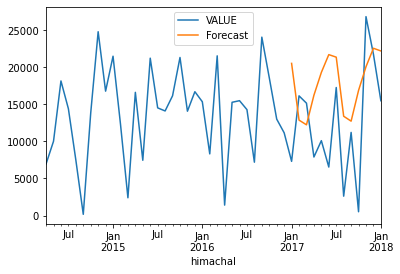

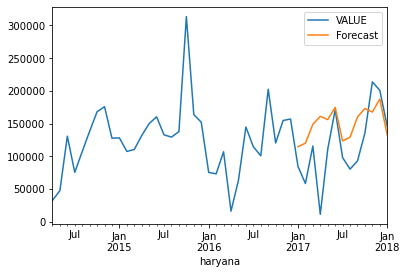

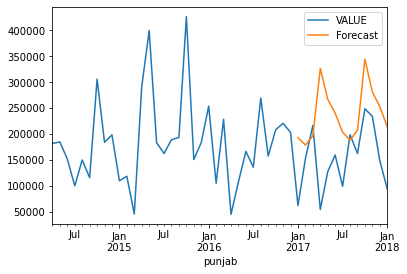

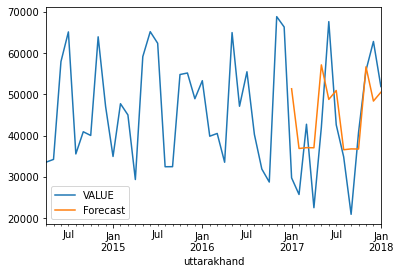

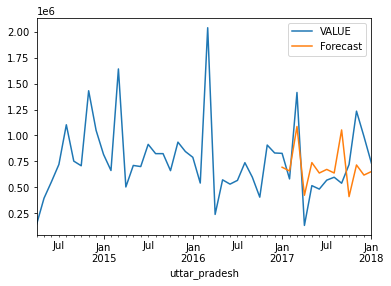

In [254]:
datasets={'himachal':Actual_Forecast_Df_himachal,
          'haryana':Actual_Forecast_Df_haryana,
          'punjab':Actual_Forecast_Df_punjab,
          'uttarakhand':Actual_Forecast_Df_uttarakhand,
          'uttar_pradesh':Actual_Forecast_Df_uttar_pradesh
          }
for i,j in datasets.items():
    j.plot()
    plt.xlabel(i)
    

In [255]:
for i,j in datasets.items():
    Validation_Df = j[-12:].copy()
    print(i)
    print(np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100)
    mape=np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100
    row=pd.Series([i,mape,'add','add',12])
    d=d.append(row,ignore_index=True)

himachal
348.6439671112654
haryana
143.75434073605365
punjab
90.49194370401014
uttarakhand
26.87029632319507
uttar_pradesh
48.68798364316063


In [256]:
d

,0,1
0,himachal,456.695516
1,haryana,90.688157
2,punjab,82.582861
3,uttarakhand,38.011457
4,uttar_pradesh,27.068845
5,himachal,348.643967
6,haryana,143.754341
7,punjab,90.491944
8,uttarakhand,26.870296
9,uttar_pradesh,48.687984


seasonality:12,season,trend

0	himachal	456.695516	mul	add
1	haryana	90.688157	mul	add
2	punjab	82.582861	mul	add
3	uttarakhand	38.011457	mul	add
4	uttar_pradesh	27.068845	mul	add

seasonality:6,season,trend
0	himachal	348.643967	mul	add
1	haryana	143.754341	mul	add
2	punjab	90.491944	mul	add
3	uttarakhand	26.870296	mul	add
4	uttar_pradesh	48.687984	mul	add

seasonality:4,season,trend

0	himachal	419.222965	mul	add
1	haryana	177.010465	mul	add
2	punjab	61.888373	mul	add
3	uttarakhand	46.238231	mul	add
4	uttar_pradesh	52.305404	mul	add

seasonality:3,season,trend

0	himachal	329.721774	mul	add
1	haryana	185.670891	mul	add
2	punjab	55.195833	mul	add
3	uttarakhand	38.943877	mul	add
4	uttar_pradesh	48.856681	mul	add


seasonality:4,season,trend

0	himachal	390.047384	mul	mul
1	haryana	197.737513	mul	mul
2	punjab	63.519611	mul	mul
3	uttarakhand	40.568436	mul	mul
4	uttar_pradesh	52.258116	mul	mul

seasonality:3,season,trend
0	himachal	313.566491	mul	mul
1	haryana	255.247715	mul	mul
2	punjab	53.711780	mul	mul
3	uttarakhand	39.327329	mul	mul
4	uttar_pradesh	55.694956	mul	mul

seasonality:6,season,trend

0	1	2	3
0	himachal	380.117164	mul	mul
1	haryana	146.172778	mul	mul
2	punjab	82.454089	mul	mul
3	uttarakhand	26.918197	mul	mul
4	uttar_pradesh	56.322542	mul	mul
    
seasonality:12,season,trend
0	himachal	531.641412	mul	mul
1	haryana	94.023964	mul	mul
2	punjab	113.587332	mul	mul
3	uttarakhand	38.952727	mul	mul
4	uttar_pradesh	27.070549	mul	mul


seasonality:12,season,trend
0	himachal	349.333579	add	add
1	haryana	98.538182	add	add
2	punjab	52.256885	add	add
3	uttarakhand	34.144128	add	add
4	uttar_pradesh	17.609343	add	add

seasonality:6
0	1	2	3
0	himachal	328.020511	add	add
1	haryana	155.729803	add	add
2	punjab	80.865532	add	add
3	uttarakhand	26.418930	add	add
4	uttar_pradesh	44.967716	add	add

seasonality:4
	0	1	2	3
0	himachal	348.264654	add	add
1	haryana	172.745686	add	add
2	punjab	61.541249	add	add
3	uttarakhand	43.694771	add	add
4	uttar_pradesh	62.726936	add	add

seasonality:3
	0	1	2	3
0	himachal	329.783897	add	add
1	haryana	192.527389	add	add
2	punjab	57.590777	add	add
3	uttarakhand	38.777003	add	add
4	uttar_pradesh	48.056489	add	add


seasonality:3,season,trend
0	himachal	310.876738	add	mul
1	haryana	267.597012	add	mul
2	punjab	56.860149	add	mul
3	uttarakhand	39.168607	add	mul
4	uttar_pradesh	51.120155	add	mul

seasonality:12,season,trend
    
0	himachal	367.472565	add	mul
1	haryana	103.757705	add	mul
2	punjab	54.236348	add	mul
3	uttarakhand	34.533737	add	mul
4	uttar_pradesh	16.673459	add	mul

seasonality:6,season,trend

0	1	2	3
0	himachal	295.414905	add	mul
1	haryana	158.100881	add	mul
2	punjab	86.136785	add	mul
3	uttarakhand	26.471992	add	mul
4	uttar_pradesh	46.337096	add	mu
    
seasonality:4,season,trend
0	himachal	295.414905	add	mul
1	haryana	158.100881	add	mul
2	punjab	86.136785	add	mul
3	uttarakhand	26.471992	add	mul
4	uttar_pradesh	46.337096	add	mul